## 2.4 ADALINE

### 概要

- ADALINE: Adaptive Linear Neuron
- パーセプトロンの改良とみなせる
- コスト関数への理解
  - 回帰モデル、ロジスティック回帰、SVMへの理解の土台に
- 日本ではそれほど有名ではないかもしれない（あまり聞いたことがないし、日本語の資料が非常に少ない）

### パーセプトロンとの違い

- パーセプトロンでは単位ステップ関数だが、ADALINEでは線形活性化関数に基いて重み更新する
- ただしADALINEでの線形活性化関数は恒等関数：$\phi(w^Tx) = w^Tx$
- この線形活性化関数は学習では使われるが、予測では量子化器（quantizer）を使用
- この量子化器は単位ステップ関数に似ている

下図がADALINEの全体図
![](img/chap02_adaline.png)

## 2.5 勾配降下法によるコスト関数の最小化

- **目的関数 (objective function)** の定義
  - 学習過程で最適化される
  - 多くの場合、**目的関数＝コスト関数 (cost function)**
    - これを最小化することが最適化につながる
    - 参考：凸最適化問題
- ADALINE の場合、目的関数を$J$とすると、以下のように定義できる（誤差平方和）

$$
J(w) = \frac{1}{2} \sum_i (y^{(i)} - \phi (z^{(i)}))^2
$$

- これを簡単に解釈すると、「予測した数値と本当の数値（教師データ）との距離（どれくらい違うか／合っているか）を求めている」
  - $i$番目のデータに対しての
  - 教師データ: $y^{(i)}$
  - 予測値: $\phi (z^{(i)})$
- なぜこのような形に設計したのか
  - 微分できるから
  - **微分できるから**
- 微分可能→勾配が求められる→**勾配降下法（gradient descent）**が使える
- 勾配効果法は単純だけど強力な最適化アルゴリズム
  - 近年有効な最適化手法の多くはこれに基づいている（[参考](http://postd.cc/optimizing-gradient-descent/)）
    - SGD (Stochastic Gradient Descent)
    - Momentum
    - AdaGrad
    - AdaDelta
    - Adam
    - etc...
- 直感的なイメージ（[GIF](http://shogo82148.github.io/homepage/memo/algorithm/steepest-descent/steepest.svg)）
- 何をやっているかというと、

ステップごとに、予め決められていたステップ幅分の重み更新をする:

$w \leftarrow W + \Delta w$

ステップ幅は負の勾配に、学習率$\eta$をかけたもの:

$\Delta w = - \eta \nabla J(w)$

ここの$\nabla J(w)$は以下のように求められる（$i$番目のデータ、$j$番目の特徴量）:

$\nabla J(w) = \frac{\partial J}{\partial w_j} = - \sum_i ( y^{(i)} - \phi (z^{(i)})) x^{(i)}_j$

つまり$\Delta w_j$は:

$
\begin{eqnarray}
\Delta w_j &=& - \eta \nabla J(w) \\
  &=& - \eta \frac{\partial J}{\partial w_j} \\
  &=& \eta \sum_i ( y^{(i)} - \phi (z^{(i)})) x^{(i)}_j
\end{eqnarray}
$

更新式に当てはめると:

$
\begin{eqnarray}
w &\leftarrow& W + \Delta w \\
  &\leftarrow& W + \eta \sum_i ( y^{(i)} - \phi (z^{(i)})) x^{(i)}_j
\end{eqnarray}
$

## 以下実装

### やりたいこと

- Irisデータセットを使って、4つの特徴量からその種類を予測したい

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
import pandas as pd
import collections

### Iris dataset

In [8]:
DATA_URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
COLS = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class']
CLASSES = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']

iris_df = pd.read_csv(DATA_URL, header=None)
iris_df.columns = COLS
iris_df[:3]

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa


In [37]:
# classes
print("classes: {}".format(iris_df['class'].unique()))
for k, v in collections.Counter(iris_df['class']).items():
  print(k, v)

classes: ['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']
Iris-virginica 50
Iris-setosa 50
Iris-versicolor 50


#### その他どんなデータなのか

→ [参考]()

### まずデータを作る

- 今回は 7:3 の割合で
- 学習データ: 各クラス 35
  - 合計: 35 $\times$ クラス数（今回は2クラスなので70）
- テストデータ: 各クラス 15
  - 合計: 15 $\times$ クラス数（今回は2クラスなので30）
- シャッフル

In [210]:
SEED = 3
N_PER_CLASS = 50
N_TRAIN_RATE = .9
N_TEST_RATE = 1 - N_TRAIN_RATE
N_TRAIN = int(N_TRAIN_RATE * N_PER_CLASS)
N_TEST = int(N_PER_CLASS - N_TRAIN)
s = np.random.RandomState(SEED)
perm = s.permutation(N_PER_CLASS)

In [211]:
train_df = pd.DataFrame([], columns=COLS)
test_df = pd.DataFrame([], columns=COLS)
for i in range(len(CLASSES[:2])):
  tmp_df = iris_df[iris_df['class'] == CLASSES[i]]
  tmp_train_df = tmp_df.take(perm)[:N_TRAIN]
  tmp_test_df = tmp_df.take(perm)[N_TRAIN:]
  train_df = train_df.append(tmp_train_df, ignore_index=True)
  test_df = test_df.append(tmp_test_df, ignore_index=True)

In [212]:
print("TRAIN SET: {}, TEST SET: {}".format(train_df.shape, test_df.shape))

TRAIN SET: (90, 5), TEST SET: (10, 5)


In [328]:
train_x = train_df.iloc[:, :2].values
train_y = train_df.iloc[:, 4].values
test_x = test_df.iloc[:, :2].values
test_y = test_df.iloc[:, 4].values

train_y = np.where(train_y == CLASSES[0], -1, 1)
test_y = np.where(test_y == CLASSES[0], -1, 1)

### データができたのでいよいよADALINE実装

#### 擬似コード

```
INIT weights, loss
FOR iter IN n_iter:
  CALC output
  CALC errors
  UPDATE weights
  CALC loss
```

- `output`: net input function $\phi(z)$ の出力。ADALINEAR では $\phi(z) = z$ となる恒等関数
- `errors`: $y^{(i)} - \phi(z)$
- `weights`: $\eta \sum_i ( y^{(i)} - \phi (z^{(i)})) x^{(i)}_j$
- `loss`: $\frac{1}{2} \sum_i (y^{(i)} - \phi (z^{(i)}))^2$

In [291]:
class AdalineGD(object):
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.

    Attributes
    -----------
    w_ : 1d-array
        Weights after fitting.
    errors_ : list
        Number of misclassifications in every epoch.

    """
    def __init__(self, eta:float=0.01, n_iter:int=50):
        self.eta = eta
        self.n_iter = n_iter

    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples]
            Target values.

        Returns
        -------
        self : object

        """
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            # Please note that the "activation" method has no effect
            # in the code since it is simply an identity function. We
            # could write `output = self.net_input(X)` directly instead.
            # The purpose of the activation is more conceptual, i.e.,  
            # in the case of logistic regression, we could change it to
            # a sigmoid function to implement a logistic regression classifier.
            output = self.activation(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """Compute linear activation"""
        return self.net_input(X)

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(X) >= 0.0, 1, -1)

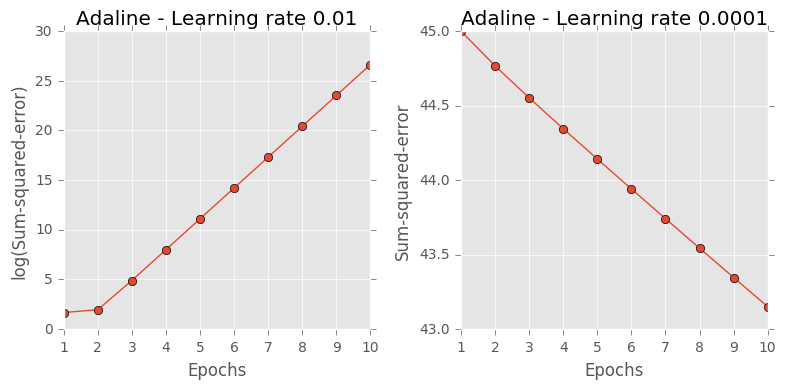

In [329]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

ada1 = AdalineGD(n_iter=10, eta=0.01).fit(train_x, train_y)
ax[0].plot(range(1, len(ada1.cost_) + 1), np.log10(ada1.cost_), marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('log(Sum-squared-error)')
ax[0].set_title('Adaline - Learning rate 0.01')

ada2 = AdalineGD(n_iter=10, eta=0.0001).fit(train_x, train_y)
ax[1].plot(range(1, len(ada2.cost_) + 1), ada2.cost_, marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Sum-squared-error')
ax[1].set_title('Adaline - Learning rate 0.0001')

plt.tight_layout()
plt.show()

#### スケーリング

各特徴量の平均を0, 標準偏差を1とすると、スケーリングされたデータは

$
x_j^{\prime} = \frac{x_j - \mu_j}{\sigma_j}
$

In [330]:
train_x_std = np.copy(train_x)
for i in range(train_x.shape[1]):
  train_x_std[:, i] = (train_x[:, i] - train_x[:, i].mean()) / train_x[:, i].std()

In [331]:
print(train_x[:10])
print(train_x_std[:10])

[[ 4.8  3. ]
 [ 5.1  3.4]
 [ 4.9  3.1]
 [ 4.6  3.2]
 [ 5.4  3.4]
 [ 5.2  3.4]
 [ 4.3  3. ]
 [ 5.3  3.7]
 [ 4.8  3. ]
 [ 4.6  3.4]]
[[-1.11794809 -0.21541057]
 [-0.61902911  0.60956608]
 [-0.95164176 -0.00916641]
 [-1.45056074  0.19707776]
 [-0.12011013  0.60956608]
 [-0.45272278  0.60956608]
 [-1.94947973 -0.21541057]
 [-0.28641645  1.22829857]
 [-1.11794809 -0.21541057]
 [-1.45056074  0.60956608]]


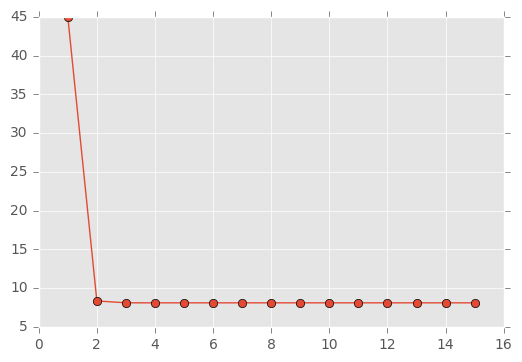

In [332]:
ada = AdalineGD(eta=0.01, n_iter=15).fit(train_x_std, train_y)
plt.plot(range(1, len(ada.cost_) + 1), ada.cost_, marker='o')
plt.show()

In [319]:
da = AdalineGD(n_iter=15, eta=0.01)
ada.fit(X_std, y)

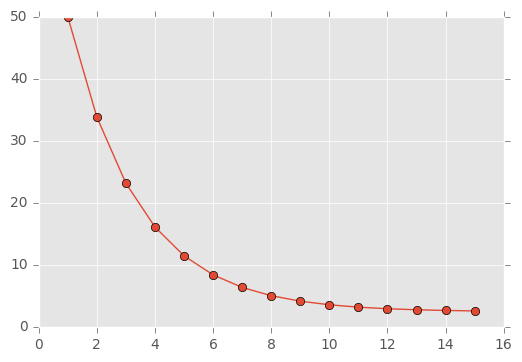

In [320]:
plt.plot(range(1, len(ada.cost_) + 1), ada.cost_, marker='o')

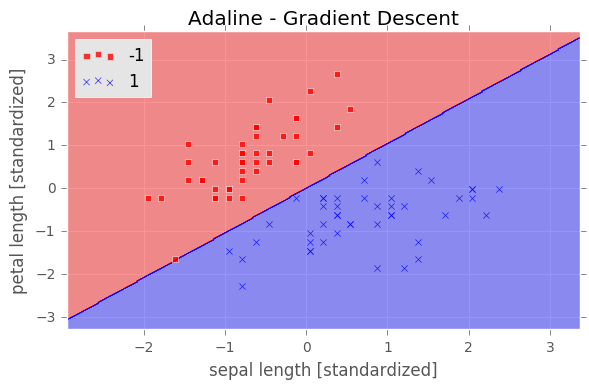

In [334]:
plot_decision_regions(train_x_std, train_y, classifier=ada)
plt.title('Adaline - Gradient Descent')
plt.xlabel('sepal length [standardized]')
plt.ylabel('petal length [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('./adaline_2.png', dpi=300)
plt.show()

---

## SGD

In [335]:
from numpy.random import seed

class AdalineSGD(object):
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.

    Attributes
    -----------
    w_ : 1d-array
        Weights after fitting.
    errors_ : list
        Number of misclassifications in every epoch.
    shuffle : bool (default: True)
        Shuffles training data every epoch if True to prevent cycles.
    random_state : int (default: None)
        Set random state for shuffling and initializing the weights.
        
    """
    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        if random_state:
            seed(random_state)
        
    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples]
            Target values.

        Returns
        -------
        self : object

        """
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = []
            for xi, target in zip(X, y):
                cost.append(self._update_weights(xi, target))
            avg_cost = sum(cost) / len(y)
            self.cost_.append(avg_cost)
        return self

    def partial_fit(self, X, y):
        """Fit training data without reinitializing the weights"""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self

    def _shuffle(self, X, y):
        """Shuffle training data"""
        r = np.random.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        """Initialize weights to zeros"""
        self.w_ = np.zeros(1 + m)
        self.w_initialized = True
        
    def _update_weights(self, xi, target):
        """Apply Adaline learning rule to update the weights"""
        output = self.net_input(xi)
        error = (target - output)
        self.w_[1:] += self.eta * xi.dot(error)
        self.w_[0] += self.eta * error
        cost = 0.5 * error**2
        return cost
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """Compute linear activation"""
        return self.net_input(X)

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(X) >= 0.0, 1, -1)

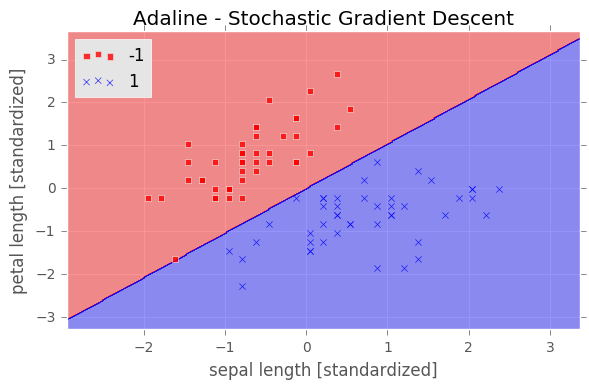

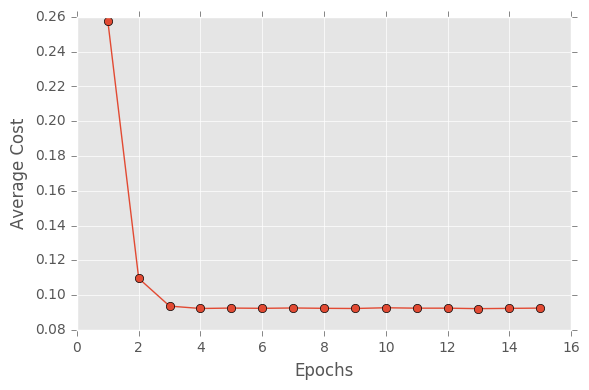

In [340]:
ada = AdalineSGD(n_iter=15, eta=0.01, random_state=1)
ada.fit(train_x_std, train_y)

plot_decision_regions(train_x_std, train_y, classifier=ada)
plt.title('Adaline - Stochastic Gradient Descent')
plt.xlabel('sepal length [standardized]')
plt.ylabel('petal length [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
#plt.savefig('./adaline_4.png', dpi=300)
plt.show()

plt.plot(range(1, len(ada.cost_) + 1), ada.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Average Cost')

plt.tight_layout()
# plt.savefig('./adaline_5.png', dpi=300)
plt.show()

---

## Appendix

In [324]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=cmap(idx),
                    marker=markers[idx], label=cl)